# Import Libraries and Data

## Basics

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from copy import deepcopy

## Preprocessing

In [125]:
from scipy.stats import iqr, boxcox
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.decomposition import PCA

## Algorithms

In [126]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import mord as m

## Evaluation

In [127]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, LeaveOneOut, train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, recall_score
from sklearn.utils.multiclass import unique_labels
import graphviz
from scipy.stats import chi2_contingency

def confusion_matrix_report(y_true, y_pred):    
    cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
    column_width = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
    report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
    for i, label1 in enumerate(labels):
        report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
    return report

import math

def calc_rmse(predicted, target):
    error = pd.DataFrame()
    error['Text'] = target + predicted
    conditions = [(error['Text'] == "1_low1_low"),
                 (error['Text'] == "2_middle2_middle"),
                 (error['Text'] == "3_high3_high"),
                 (error['Text'] == "1_low3_high"),
                 (error['Text'] == "3_high1_low")]
    choices = [0,0,0,2,2]
    error['numeric'] = np.select(conditions, choices, default = 1)
    rmse = math.sqrt((error['numeric']*error['numeric']).mean())
    print(rmse)
    return rmse

def evaluation(prediction, label):
    print(classification_report(label, prediction))
    print(confusion_matrix_report(label, prediction))
    rmse = calc_rmse(prediction, label)
    print("Root Mean squared Error: {}".format(rmse))

## Data

In [128]:
red = pd.read_csv("./data/winequality-red1.csv")
white = pd.read_csv("./data/winequality-white1.csv")

# Data Manipulation and Preprocessing

In [129]:
conditions_white = [(white['quality'] <= 5),
              (white['quality'] >= 7)]
choices = ['1_low', '3_high']
white['quality_class'] = np.select(conditions_white, choices, default = '2_middle')
conditions_red = [(red['quality'] <= 5),
              (red['quality'] >= 7)]
red['quality_class'] = np.select(conditions_red, choices, default = '2_middle')

In [130]:
white_data = white.drop(['quality', 'quality_class'], axis = 1)
red_data = red.drop(['quality', 'quality_class'], axis = 1)

In [131]:
white_label = white['quality_class']
red_label = red['quality_class']

In [132]:
import math

def calc_rmse(predicted, target):
    error = pd.DataFrame()
    error['Text'] = target + predicted
    conditions = [(error['Text'] == "1_low1_low"),
                 (error['Text'] == "2_middle2_middle"),
                 (error['Text'] == "3_high3_high"),
                 (error['Text'] == "1_low3_high"),
                 (error['Text'] == "3_high1_low")]
    choices = [0,0,0,2,2]
    error['numeric'] = np.select(conditions, choices, default = 1)
    rmse = math.sqrt((error['numeric']*error['numeric']).mean())
    #print(rmse)
    return rmse

# Classification - Red Wine

## Naive Bayes Classifier

In [259]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

classifiers = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB()]

for clf in classifiers:
    prediction = cross_val_predict(clf, red_data, red_label, cv=cv)
    name = clf.__class__.__name__
    
    print("-"*50)
    print(name)
    
    print('****Results****')
    acc = accuracy_score(red_label, prediction)
    print("Accuracy: {:.4%}".format(acc))
    evaluation(prediction, red_label)

--------------------------------------------------
GaussianNB
****Results****
Accuracy: 60.5378%
             precision    recall  f1-score   support

      1_low       0.71      0.71      0.71       744
   2_middle       0.54      0.50      0.52       638
     3_high       0.45      0.56      0.50       217

avg / total       0.61      0.61      0.61      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     529      187       28
2_middle     198      317      123
  3_high      16       79      122

Root Mean squared Error: 0.6907772674826483
--------------------------------------------------
MultinomialNB
****Results****
Accuracy: 46.0913%
             precision    recall  f1-score   support

      1_low       0.63      0.49      0.55       744
   2_middle       0.48      0.41      0.44       638
     3_high       0.24      0.53      0.33       217

avg / total       0.52      0.46      0.48      1599

         _______Prediction_______
           1_l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gaussian Naive Bayes shows the best results

In [260]:
model_bayes = GaussianNB()
prediction_red = cross_val_predict(model_bayes, red_data, red_label, cv=cv)

## Improving Power of NB

### Feature selection

Text(0.5,0,'Relative Importance')

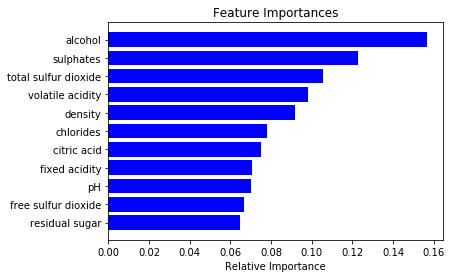

In [261]:
### Using Random Forest to find feature importances ###
### https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

rfc = RandomForestClassifier(random_state=42)
rfc = rfc.fit(red_data, red_label)

features = red_data.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

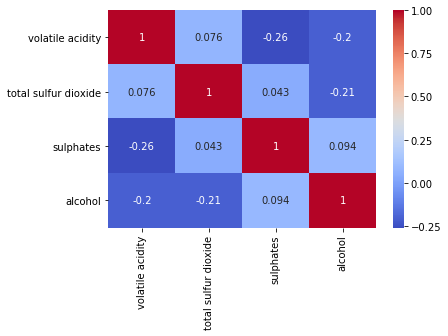

In [262]:
### Find correlations in data

sns.heatmap(red_data_selected.corr(),cmap='coolwarm',annot=True)

In [263]:
### Remove highly correlated variables ###
red_data_selected = deepcopy(red_data)
red_data_selected.pop("free sulfur dioxide") ## low importances, thus removed
red_data_selected.pop("pH") # low importances, thus removed
red_data_selected.pop("residual sugar") # low importances, thus removed
red_data_selected.pop("chlorides") # low importances, thus removed
red_data_selected.pop("citric acid") # # low importances, thus removed
red_data_selected.pop("fixed acidity") # # low importances, thus removed
red_data_selected.pop("density") # Highly correlated with alcohol, thus removed




#red_data_selected.pop("total sulfur dioxide")
#red_data_selected.pop("sulphates")
#red_data_selected.pop("volatile acidity")
#red_data_selected.pop("alcohol") # kept as most important predictor

prediction_red_selected = cross_val_predict(model_bayes, red_data_selected, red_label, cv=cv)

After feature selection F1 score increased by 0.02 and R2 decreased by 0.06

Alcohol, sulphates, total sulphur dioxide and volatile acidity are chosen for the models

### Data Transformations

In [264]:
### Transform data to get a normal distribution via logarithm ###

red_data_selected_log = np.log(red_data_selected)

prediction_red_selected_log = cross_val_predict(model_bayes, red_data_selected_log, red_label, cv=cv)


In [265]:
red_data_log1 = np.log(red_data + 1)

prediction_red_log1 = cross_val_predict(model_bayes, red_data_log1, red_label, cv=cv)

In [266]:
#sns.pairplot(red_data_corrout)
#sns.pairplot(red_data_corrout_log)
#sns.pairplot(red_data_log1)

In [279]:
### Try to understand the decision boundary ###


NotFittedError: This GaussianNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Comparison

In [267]:
prediction = [prediction_red,
             prediction_red_selected,
             prediction_red_selected_log,
             prediction_red_log1]

method = ["GNB (normal)", 
          "GNB selected", 
          "GNB selected logarithm",
          "GNB logarithm"]

for i, j in zip(prediction, method):
    print("-"*50)
    print(j)
    evaluation(i, red_label)

--------------------------------------------------
GNB (normal)
             precision    recall  f1-score   support

      1_low       0.71      0.71      0.71       744
   2_middle       0.54      0.50      0.52       638
     3_high       0.45      0.56      0.50       217

avg / total       0.61      0.61      0.61      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     529      187       28
2_middle     198      317      123
  3_high      16       79      122

Root Mean squared Error: 0.6907772674826483
--------------------------------------------------
GNB selected
             precision    recall  f1-score   support

      1_low       0.72      0.76      0.74       744
   2_middle       0.56      0.59      0.57       638
     3_high       0.56      0.35      0.43       217

avg / total       0.63      0.64      0.63      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     568      170        6
2_middle     

Transforming the data to normal distribution does not improve the result.

## Classification - White wine

In [142]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

classifiers = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB()]

for clf in classifiers:
    prediction_white = cross_val_predict(clf, white_data, white_label, cv=cv)
    name = clf.__class__.__name__
    
    print("-"*50)
    print(name)
    
    print('****Results****')
    acc = accuracy_score(white_label, prediction_white)
    print("Accuracy: {:.4%}".format(acc))
    evaluation(prediction_white, white_label)

--------------------------------------------------
GaussianNB
****Results****
Accuracy: 49.6121%
             precision    recall  f1-score   support

      1_low       0.57      0.56      0.56      1640
   2_middle       0.52      0.35      0.42      2198
     3_high       0.41      0.70      0.52      1060

avg / total       0.51      0.50      0.49      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     914      515      211
2_middle     579      770      849
  3_high     113      201      746

Root Mean squared Error: 0.8380498079495802
--------------------------------------------------
MultinomialNB
****Results****
Accuracy: 45.7534%
             precision    recall  f1-score   support

      1_low       0.49      0.46      0.48      1640
   2_middle       0.48      0.49      0.49      2198
     3_high       0.36      0.38      0.37      1060

avg / total       0.46      0.46      0.46      4898

         _______Prediction_______
           1_l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [143]:
prediction_white = cross_val_predict(model_bayes, white_data, white_label, cv=cv)

### Feature selection

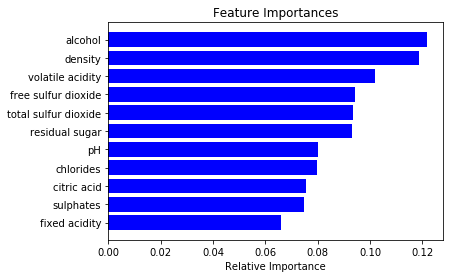

In [246]:
### Using Random Forests feature importances
### https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

rfc = RandomForestClassifier(random_state=42)
rfc = rfc.fit(white_data, white_label)

features = white_data.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.savefig('../wineForTheWin/importances_white.png')


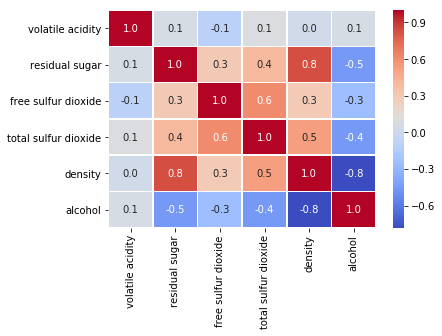

In [258]:
sns.heatmap(white_data_selected.corr(),cmap='coolwarm',annot=True, linewidths=.5, fmt= '.1f')

In [257]:
### Remove unimportant variables ###
white_data_selected = deepcopy(white_data)

white_data_selected.pop("fixed acidity") # Highly correlated with pH and low importance, thus removed
white_data_selected.pop("sulphates") # low importance, thus removed
white_data_selected.pop("chlorides") # low importances, thus removed
white_data_selected.pop("citric acid") # low importances, thus removed
white_data_selected.pop("pH") # low importances, thus removed

white_data_selected.pop("density") # Highly correlated with alcohol and residual sugar, thus removed
white_data_selected.pop("total sulfur dioxide") #Higly correlated with free sulphur dioxide, thus removed, because other correlations are higher than off free total dioxide
white_data_selected.pop("residual sugar") # correlated with alcohol and free sulfur dioxide, thus removed

#white_data_selected.pop("alcohol") # Most important predictor, thus kept
#white_data_selected.pop("free sulfur dioxide") #kept as important predictor
#white_data_selected.pop("volatile acidity") # #kept as important predictor

prediction_white_selected = cross_val_predict(model_bayes, white_data_selected, white_label, cv=cv)


Feature selection brought an increase of 0.04 for F1 and a decrease in R2 of 0.13 compared to standard model

### Data transformations

In [147]:
### Transform data to get a normal distribution via logarithm ###

white_data_selected_log = np.log(white_data_selected)

prediction_white_selected_log = cross_val_predict(model_bayes, white_data_selected_log, white_label, cv=cv)


In [148]:
white_data_log1 = np.log(white_data + 1)

prediction_white_log1 = cross_val_predict(model_bayes, white_data_log1, white_label, cv=cv)

In [149]:
prediction = [prediction_white,
             prediction_white_selected,
             prediction_white_selected_log,
             prediction_white_log1]

method = ["GNB (normal)", 
          "GNB selected", 
          "GNB selected logarithm",
          "GNB logarithm"]

for i, j in zip(prediction, method):
    print("-"*50)
    print(j)
    evaluation(i, white_label)

--------------------------------------------------
GNB (normal)
             precision    recall  f1-score   support

      1_low       0.57      0.56      0.56      1640
   2_middle       0.52      0.35      0.42      2198
     3_high       0.41      0.70      0.52      1060

avg / total       0.51      0.50      0.49      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     914      515      211
2_middle     579      770      849
  3_high     113      201      746

Root Mean squared Error: 0.8380498079495802
--------------------------------------------------
GNB selected
             precision    recall  f1-score   support

      1_low       0.64      0.50      0.56      1640
   2_middle       0.50      0.67      0.58      2198
     3_high       0.54      0.34      0.42      1060

avg / total       0.56      0.54      0.54      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     825      790       25
2_middle     

After transforming the data to normal form we can see an increase of 0.07 for F1 and a decrease in R2 of 0.15

In [236]:
### Discretize data ###
red_binned = deepcopy(red_data)
["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

for i in attributes:
    red_binned["{}".format(i)] = pd.qcut(red_binned["{}".format(i], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])

pd.qcut(red_binned["volatile acidity"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["citric acid"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["residual sugar"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["density"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["total sulfur dioxide"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["free sulfur dioxide"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["chlorides"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["sulphates"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["pH"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])
pd.qcut(red_binned["alcohol"], 4, labels=["1st quartile", "2nd quartile", "3th quartile", "4th quartile"])


SyntaxError: invalid syntax (<ipython-input-236-6394c7120400>, line 6)

In [242]:
### Discretize data ###
red_binned = deepcopy(red_data)
attributes = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

for i in attributes:
    red_binned["{}".format(i)] = pd.qcut(red_binned["{}".format(i)], 4, labels=[0, 1, 2, 3])


In [243]:
red_binned.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1,3,0,0,1,1,1,2,3,1,0
1,1,3,0,2,3,3,3,2,0,2,1
2,1,3,0,2,3,2,2,2,1,2,1
3,3,0,3,0,1,2,2,3,0,1,1
4,1,3,0,0,1,1,1,2,3,1,0


In [244]:
prediction_red_binned = cross_val_predict(model_bayes, red_binned, red_label, cv=cv)
evaluation(prediction_red_binned, red_label)

             precision    recall  f1-score   support

      1_low       0.69      0.75      0.72       744
   2_middle       0.54      0.43      0.48       638
     3_high       0.45      0.59      0.51       217

avg / total       0.60      0.60      0.59      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     558      154       32
2_middle     239      273      126
  3_high      12       76      129

Root Mean squared Error: 0.6943891993868717


# Random Forrest Classifier

In [199]:
model_rfc = RandomForestClassifier(n_estimators=200, max_features="auto", criterion="gini")

prediction_rfc_red = cross_val_predict(model_rfc, red_data, red_label, cv=cv)

print("Random Forest:")
evaluation(prediction_rfc_red, red_label)

Random Forest:
             precision    recall  f1-score   support

      1_low       0.79      0.83      0.81       744
   2_middle       0.69      0.70      0.69       638
     3_high       0.72      0.57      0.64       217

avg / total       0.74      0.74      0.74      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     617      119        8
2_middle     152      446       40
  3_high       9       84      124

Root Mean squared Error: 0.5381040535833211


In [185]:
prediction_rfc_white = cross_val_predict(model_rfc, white_data, white_label, cv=cv)

print("Random Forest:")
evaluation(prediction_rfc_white, white_label)

Random Forest:
             precision    recall  f1-score   support

      1_low       0.79      0.74      0.76      1640
   2_middle       0.69      0.78      0.73      2198
     3_high       0.78      0.64      0.70      1060

avg / total       0.74      0.74      0.74      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low    1215      407       18
2_middle     308     1715      175
  3_high      22      356      682

Root Mean squared Error: 0.5357760177541451


In [156]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
pprint(rfc.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [157]:
param_grid = {'n_estimators': [200, 500],
               'max_features': ['auto', 'sqrt', "log2"],
               'max_depth': [4,5,6,7,8,9,10],
               "criterion": ["gini", "entropy"]}

In [200]:
param_grid = {'n_estimators': [10, 25, 50, 100, 200, 300, 400, 500],
               'max_features': ["auto", "sqrt", "log2"]
             }

In [201]:
grid_crf = GridSearchCV(estimator = model_rfc, param_grid = param_grid, 
                          cv=cv)
grid_crf.fit(red_data, red_label)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [202]:
grid_crf.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

In [208]:
rfc_grid = RandomForestClassifier(n_estimators=100, max_features="sqrt")

prediction_rfc_grid_red = cross_val_predict(model_rfc, red_data, red_label, cv=cv)

print("Random Forest:")
evaluation(prediction_rfc_grid_red, red_label)

Random Forest:
             precision    recall  f1-score   support

      1_low       0.78      0.83      0.81       744
   2_middle       0.68      0.69      0.69       638
     3_high       0.76      0.59      0.66       217

avg / total       0.74      0.74      0.74      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     618      122        4
2_middle     162      439       37
  3_high       8       81      128

Root Mean squared Error: 0.5304958917673055


# Theory

## Naive Bayes Classifier

https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/:

Pros:

- It is easy and fast to predict class of test data set. It also perform well in multi class prediction
- When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
- It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).

Cons:

- If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”. To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.
- On the other side naive Bayes is also known as a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
- Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.
 

### Trying to improve the power of Naive Bayes

https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/:

- If continuous features do not have normal distribution, we should use transformation or different methods to convert it in normal distribution.
- If test data set has zero frequency issue, apply smoothing techniques “Laplace Correction” to predict the class of test data set.
- Remove correlated features, as the highly correlated features are voted twice in the model and it can lead to over inflating importance.
- Naive Bayes classifiers has limited options for parameter tuning like alpha=1 for smoothing, fit_prior=[True|False] to learn class prior probabilities or not and some other options (look at detail here). I would recommend to focus on your  pre-processing of data and the feature selection.
- You might think to apply some classifier combination technique like ensembling, bagging and boosting but these methods would not help. Actually, “ensembling, boosting, bagging” won’t help since their purpose is to reduce variance. Naive Bayes has no variance to minimize.

Naive Bayes verbessern:
- Fisher method
- One against many approach bei classess
- Tuning
- Ensembling, Boosting, bagging, etc.

## Train/test-split vs. Stratified 10-fold Cross-Validation vs. LOOCV

k-fold-CrossValidation
-	Importantly, each observation in the data sample is assigned to an individual group and stays in that group for the duration of the procedure. This means that each sample is given the opportunity to be used in the hold out set 1 time and used to train the model k-1 times.
-	It is also important that any preparation of the data prior to fitting the model occur on the CV-assigned training dataset within the loop rather than on the broader data set. This also applies to any tuning of hyperparameters. A failure to perform these operations within the loop may result in data leakage and an optimistic estimate of the model skill.

Configuration of k
- A poorly chosen value for k may result in a mis-representative idea of the skill of the model, such as a score with a high variance (that may change a lot based on the data used to fit the model), or a high bias, (such as an overestimate of the skill of the model).

Three common tactics for choosing a value for k are as follows:
-	Representative: The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset.
-	k=10: The value for k is fixed to 10, a value that has been found through experimentation to generally result in a model skill estimate with low bias a modest variance.
-	k=n: The value for k is fixed to n, where n is the size of the dataset to give each test sample an opportunity to be used in the hold out dataset. This approach is called leave-one-out cross-validation.
It is preferable to split the data sample into k groups with the same number of samples, such that the sample of model skill scores are all equivalent!

Reasons for cross-validation:
-	avoids overfitting
-	all available data is used for training, equal splits because stratified, everyone is represented


Further questions?:
- Is the classifier better in detecting average, good or bad wines? What could be the reason?
- What can this classifier be used for in reality? What benefits does it have?
- Comparison to regression techniques?
- What follows from our split?